In [1]:
import PyRadioTrace.models as models
from PyRadioTrace.models import GeoModel
from PyRadioTrace.jones_stephenson import Raytracer
import datetime as dt 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as const
import tqdm 

In [2]:
date =dt.datetime(2015, 1, 1) # date of interest
neutral = models.ScaleHeight(N0 = 700, H = 7e3)
magneto = models.IGRF(date)
iono = models.IRIModel(date)


In [3]:
neutral(0,0, 100.)

(np.float64(1.0006900710896467),
 array([-9.85815842e-08,  0.00000000e+00,  0.00000000e+00]))

In [4]:
iono(0,0,9, with_derivatives=False)

(np.float64(4000433.02524386),
 array([170.26644362,   0.        ,   0.        ]))

In [5]:
altitudes = np.arange(0,1000,1)*1e3 # meters
ne_profile = np.zeros_like(altitudes)
for ind, alt in enumerate(altitudes):
    ne_profile[ind] = iono(0,0,alt)[0]

In [6]:
omega0 = np.sqrt(ne_profile * const.e**2 / (const.epsilon_0 * const.m_e) )/ (2*np.pi) # Hz
plasma_freqs = np.vstack((omega0,omega0))

In [7]:
Raytrace  =  Raytracer(iono = iono, magneto = None, neutral = neutral)

In [8]:
lat = 0
lon = 0
alt = 0
az = 90
el = 45
# f = 1575.42e6
# f = 8.5e6
freqs = np.arange(1, 10, 0.05)*1e6


In [9]:
path_lons_total = []
path_alts_total = []
path_freqs_total = []
for f in tqdm.tqdm(freqs):
    max_distance = 1000e3
    solution = Raytrace.ray_propagate(lat, lon, alt, az, el, f, group_path_distances=np.arange(0,max_distance,100), atol = 1e-6)
    path_lats, path_lons, path_alts = GeoModel.convert_spherical_to_lla(solution.y[0,:], solution.y[1,:], solution.y[2,:])
    path_lons_total = np.concatenate((path_lons_total, path_lons))
    path_freqs_total = np.concatenate((path_freqs_total, f*np.ones_like(path_lons)))
    path_alts_total = np.concatenate((path_alts_total, path_alts))

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:09<00:00, 19.11it/s]


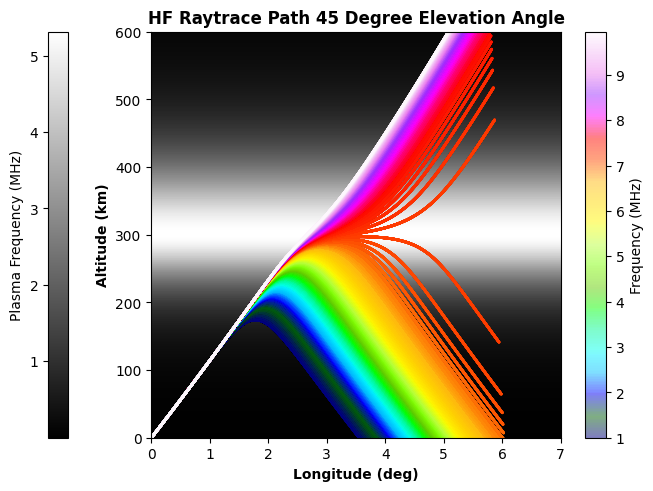

In [10]:
fig, ax = plt.subplots(layout='constrained')
im = ax.imshow(plasma_freqs.transpose()/1e6, interpolation='nearest',
                cmap='gray',
                aspect='auto',
                origin='lower',
                extent=[0, 10, 0, 1000])
map = ax.scatter(path_lons_total, path_alts_total/1e3, s=1, c=path_freqs_total/1e6, cmap='gist_ncar', alpha=0.5)
ax.set_xlabel('Longitude (deg)', fontweight = 'bold')
ax.set_ylabel('Altitude (km)', fontweight = 'bold')
ax.set_ylim([0,600])
ax.set_xlim([0,7])
ax.set_title('HF Raytrace Path 45 Degree Elevation Angle', fontweight = 'bold')
fig.colorbar(map, label='Frequency (MHz)')
cb = fig.colorbar(im, location='left', label ='Plasma Frequency (MHz)')

In [11]:
lat = 0
lon = 0
alt = 0
az = 90
elevations = np.arange(5,80,0.5)
# f = 1575.42e6
f = 4e6

omega = 2*np.pi*f

In [12]:
path_lons_total = []
path_alts_total = []
path_els_total = []
for el in tqdm.tqdm(elevations):
    max_distance = 1000e3
    solution = Raytrace.ray_propagate(lat, lon, alt, az, el, f, group_path_distances=np.arange(0,max_distance,100))
    path_lats, path_lons, path_alts = GeoModel.convert_spherical_to_lla(solution.y[0,:], solution.y[1,:], solution.y[2,:])
    path_lons_total = np.concatenate((path_lons_total, path_lons))
    path_els_total = np.concatenate((path_els_total, el*np.ones_like(path_lons)))
    path_alts_total = np.concatenate((path_alts_total, path_alts))

100%|██████████| 150/150 [00:02<00:00, 51.55it/s]


Text(0.5, 1.0, 'HF Raytrace Path Elevation Sweep at 4 MHz')

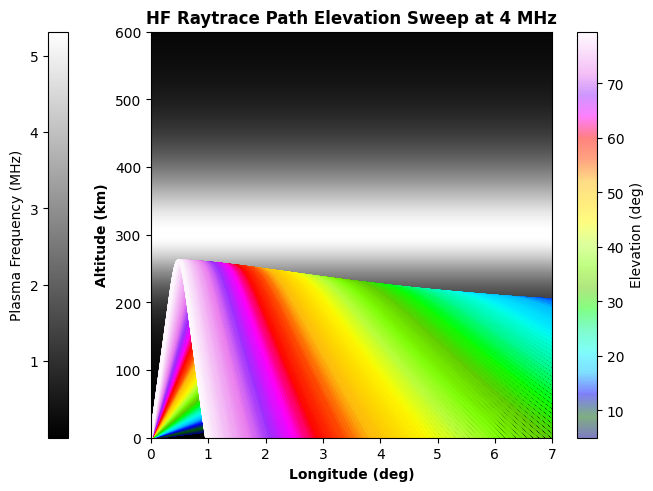

In [13]:
fig, ax = plt.subplots(layout='constrained')
im = ax.imshow(plasma_freqs.transpose()/1e6, interpolation='nearest',
                cmap='gray',
                aspect='auto',
                origin='lower',
                extent=[0, 10, 0, 1000])
map = ax.scatter(path_lons_total, path_alts_total/1e3, s=1, c=path_els_total, cmap='gist_ncar', alpha=0.5)
ax.set_xlabel('Longitude (deg)', fontweight = 'bold')
ax.set_ylabel('Altitude (km)', fontweight = 'bold')
ax.set_ylim([0,600])
ax.set_xlim([0,7])
plt.colorbar(map, label='Elevation (deg)')
cb = fig.colorbar(im, location='left', label ='Plasma Frequency (MHz)')
ax.set_title('HF Raytrace Path Elevation Sweep at 4 MHz', fontweight = 'bold')
